# Drought Event Tracking

a. stein 7.8.2022

A useful piece of information would be how big different droughts get because each pixel is impacted by its neighbor. Through blob tracking, I might be able to detect different drought events and their areas over time as they come and go.

In [23]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gray']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Load in data

In [24]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [25]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

The most useful package for this appears to OpenCV .. here's a tutorial: https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

In [26]:
import cv2

In [27]:
test = paired_ds['USDM']
test_vals = test.sel(index=500).values

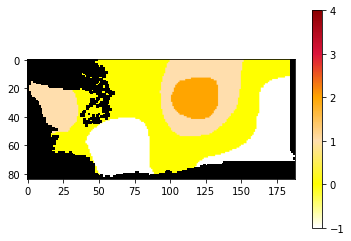

In [28]:
fig, ax = plt.subplots()

cb = ax.imshow(test_vals, vmin=-1, vmax=4, cmap=ndplot.usdm_cmap())
fig.colorbar(cb)
ax.set_facecolor('k')

Okay, I know I'm going to needs to use a binary image, so let's go ahead and use a threshold of D1

In [29]:
test_vals[test_vals < 1] = 0
test_vals[test_vals > 0] = 1

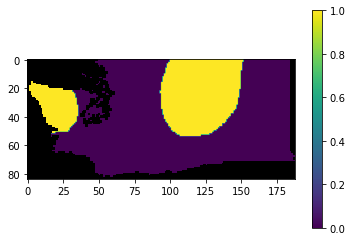

In [30]:
fig, ax = plt.subplots()

cb = ax.imshow(test_vals, vmin=0, vmax=1, cmap='viridis')
fig.colorbar(cb)
ax.set_facecolor('k')

Cool, that looks right.

Now to figure out how to make it an image ... https://www.codespeedy.com/convert-a-numpy-array-to-image-in-python/

In [31]:
from PIL import Image

In [32]:
test_vals.shape

(84, 188)

In [33]:
w, h = len(paired_ds.lon), len(paired_ds.lat)
t = (h, w, 3)
A = np.zeros(t, dtype=np.uint8)
for i in range(h):
    for j in range(w):
        val = test_vals[i,j]
        if np.isnan(val):
            val = 0
        color_val = 255*val
        color_val = np.uint8(color_val)
        #print(color_val)
        
        A[i,j]=[color_val, color_val, color_val]

img = Image.fromarray(A, 'RGB')

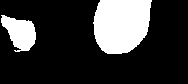

In [34]:
img

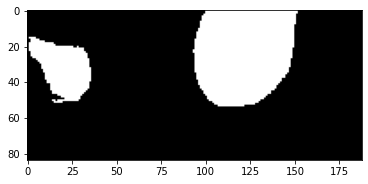

In [35]:
# double check that's right
fig, ax = plt.subplots()

ax.imshow(A, vmin=0, vmax=256)


Cool. After much debugging, that's solved.

In [36]:
gray = cv2.cvtColor(A, cv2.COLOR_RGB2GRAY)

In [37]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [38]:
output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)

In [39]:
(numLabels, labels, stats, centroids) = output

In [40]:
numLabels

2

In [41]:
labels

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [42]:
# so this is the bounding box and then the area in pixels
stats

array([[    1,     0,   151,    54,  3444],
       [    0,     0,   188,    84, 12348]], dtype=int32)

In [43]:
centroids

array([[96.97067364, 26.10481998],
       [92.53198899, 45.79389375]])

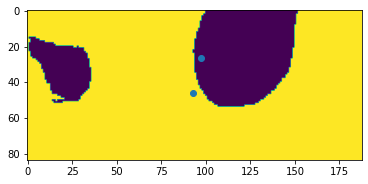

In [44]:
fig, ax = plt.subplots()

ax.imshow(labels)
ax.scatter(x=centroids[:,0], y=centroids[:,1])

In [45]:
stats[:,-1].sum()

15792

Ah, so it separated it into drought and not drought ... which isn't really what I was hoping for ...

### Scikit

Okay, this already looks soo much easier to use: https://towardsdatascience.com/image-processing-with-python-blob-detection-using-scikit-image-5df9a8380ade

In [46]:
import skimage

from skimage.io import imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table


In [47]:
label?

Signature: label(label_image, background=None, return_num=False, connectivity=None)
Docstring:
Label connected regions of an integer array.

Two pixels are connected when they are neighbors and have the same value.
In 2D, they can be neighbors either in a 1- or 2-connected sense.
The value refers to the maximum number of orthogonal hops to consider a
pixel/voxel a neighbor::

  1-connectivity     2-connectivity     diagonal connection close-up

       [ ]           [ ]  [ ]  [ ]             [ ]
        |               \  |  /                 |  <- hop 2
  [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
        |               /  |  \             hop 1
       [ ]           [ ]  [ ]  [ ]

Parameters
----------
label_image : ndarray of dtype int
    Image to label.
background : int, optional
    Consider all pixels with this value as background pixels, and label
    them as 0. By default, 0-valued pixels are considered as background
    pixels.
return_num : bool, optional
    Whether to 

In [48]:
regionprops_table?

Signature:
regionprops_table(
    label_image,
    intensity_image=None,
    properties=('label', 'bbox'),
    *,
    cache=True,
    separator='-',
    extra_properties=None,
)
Docstring:
Compute image properties and return them as a pandas-compatible table.

The table is a dictionary mapping column names to value arrays. See Notes
section below for details.

.. versionadded:: 0.16

Parameters
----------
label_image : (N, M[, P]) ndarray
    Labeled input image. Labels with value 0 are ignored.
intensity_image : (M, N[, P][, C]) ndarray, optional
    Intensity (i.e., input) image with same size as labeled image, plus
    optionally an extra dimension for multichannel data. Currently,
    this extra channel dimension, if present, must be the last axis.
    Default is None.

    .. versionchanged:: 0.18.0
        The ability to provide an extra dimension for channels was added.
properties : tuple or list of str, optional
    Properties that will be included in the resulting dictionary
 

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


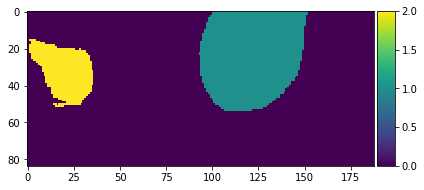

In [49]:
blobs = label(rgb2gray(A) > 0, connectivity=2)
imshow(blobs)

YAY! DIFFERENT BLOBS

List of all different properties: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

In [50]:
properties =['area','bbox','convex_area','bbox_area',
             'major_axis_length', 'minor_axis_length',
             'eccentricity']
df = pd.DataFrame(regionprops_table(blobs, properties = properties))

In [51]:
df

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity
0,2631,0,93,54,152,2685,3186,63.273580,54.261958,0.514356
1,813,15,1,52,36,933,1295,41.588572,27.159956,0.757304


let's put that in a nicer function

In [52]:
(h, w) = test_vals.shape
h, w

(84, 188)

In [53]:
from shapely.geometry import Polygon

In [54]:
def identify_drought_blob(vals:np.ndarray):
    """Using sci-kit image, identify drought event blobs.

    Parameters
    ----------
    vals: np.ndarray
        Spatial values for drought data categorized
        according to the USDM scheme for a single
        time step.

    Returns
    -------
    pd.DataFrame
        Drought blobs using connectivity 2 from
        skimage.measure.label. Blobs are binary
        definitions of drought, where the measure
        exceeds D1. Each blob is provided with
        it's area, bbox, convex_area, and coordinates
        of all cells contained within the blob.    
    """

    # first we're going to make this binary
    # by setting data in a drought to 1 and
    # not in a drought to 0, including nan

    vals[(vals < 1) | np.isnan(vals)] = 0
    vals[vals > 0] = 1

    # now we are going to convert to RGBL
    (h, w) = vals.shape
    t = (h, w, 3)
    A = np.zeros(t, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            # since we already made it binary, this
            # will make 1 vals be white and 0 vals
            # be black in our RGB array
            color_val = 255*vals[i,j]
            A[i, j] = [color_val, color_val, color_val]

    # connectivity 2 will consider diagonals as connected
    blobs = skimage.measure.label(rgb2gray(A) > 0, connectivity=2)

    properties =['area','bbox','convex_area','coords']
    df = pd.DataFrame(regionprops_table(blobs, properties=properties))
    df['drought_id'] = np.nan*np.zeros(len(df))

    return df


In [55]:
blobs = identify_drought_blob(test_vals)
blobs

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2631,0,93,54,152,2685,"[[0, 100], [0, 101], [0, 102], [0, 103], [0, 1...",NaN
1,813,15,1,52,36,933,"[[15, 1], [15, 2], [15, 3], [15, 4], [16, 2], ...",NaN


In [56]:
blob_x = blobs.coords.values[0][:,1]
blob_y = blobs.coords.values[0][:,0]

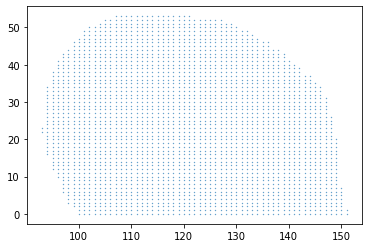

In [57]:
fig, ax = plt.subplots()

ax.scatter(blob_x, blob_y, s=0.1)

OH. That's why my conversion to Polygon keeps looking funky. `coords` gets all the pixels that are in the blob

Actually the easiest solution to detecting if they are the same via overlap is to see if they share any of the same pixels. Now this won't handle something diverging, but it's a start.

Let's test that

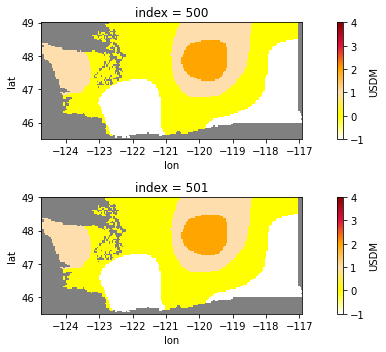

In [58]:
fig, axs = plt.subplots(2,1, figsize=(10,5))

for ax, idx in zip(axs.ravel(), [500, 501]):
    test.sel(index=idx).plot(ax=ax, vmin=-1, vmax=4, cmap=ndplot.usdm_cmap())
    ax.set_facecolor('gray')
    ax.set_aspect('equal')

plt.tight_layout()

Cool, those are pretty similar and will suffice

In [59]:
blobs_i500 = identify_drought_blob(test.sel(index=500).values)
blobs_i500

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2631,0,93,54,152,2685,"[[0, 100], [0, 101], [0, 102], [0, 103], [0, 1...",NaN
1,813,15,1,52,36,933,"[[15, 1], [15, 2], [15, 3], [15, 4], [16, 2], ...",NaN


In [60]:
blobs_i501 = identify_drought_blob(test.sel(index=501).values)
blobs_i501

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2631,0,93,54,152,2685,"[[0, 100], [0, 101], [0, 102], [0, 103], [0, 1...",NaN
1,813,15,1,52,36,933,"[[15, 1], [15, 2], [15, 3], [15, 4], [16, 2], ...",NaN


In [61]:
np.intersect1d(blobs_i501.coords.values[0], blobs_i500.coords.values[1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [62]:
blob_dict = dict()

for a, coords_i501 in enumerate(blobs_i501.coords.values):
    coords_i501_set = set(tuple(coord) for coord in coords_i501)
    for b, coords_i500 in enumerate(blobs_i500.coords.values):
        coords_i500_set = set(tuple(coord) for coord in coords_i500)
        if len(coords_i501_set.intersection(coords_i500_set)) > 0:
            blob_dict[a] = b

In [63]:
blob_dict

{0: 0, 1: 1}

Awesome. I'm not sure the efficiency of that solution but it's a solution

In [64]:
def connect_blobs_over_time(df_1:pd.DataFrame, df_2:pd.DataFrame):
    """Identify blobs shared between time frames.

    Parameters
    ---------
    df_1 : pd.DataFrame
        Blob dataframe at first time index.
    df_2 : pd.DataFrame
        Blob dataframe at second time index.

    Returns
    -------
    dict
        Indices to each dataframe denoting which
        blobs are shared, with the indices od df_2
        as the keys and df_1 as the values.
    """

    blob_dict = dict()

    for idx_1, df_1_coords in enumerate(df_1.coords.values):
        df_1_coords_set = set(tuple(coord) for coord in df_1_coords)
        for idx_2, df_2_coords in enumerate(df_2.coords.values):
            df_2_coords_set = set(tuple(coord) for coord in df_2_coords)
            if len(df_1_coords_set.intersection(df_2_coords_set)) > 0:
                blob_dict[idx_2] = idx_1

    return blob_dict

In [65]:
connect_blobs_over_time(blobs_i500, blobs_i501)

{0: 0, 1: 1}

Neat, that works.

Now how would we handle blobs splitting into new blobs or joining into one blob ...

Okay, I wrote up a scheme on my whiteboard and will try to reconvey the general principals here than put figure out code for it and test it.

### Drought Event Encoding

The method I propose is a modification on Pfaffstetter encoding, which nicely handles diverging/bifurcating/splitting objects, but does not address joining objects since it is designed for river networks which only split one way (note that this is defined for river networks by going upstream). To address this, I propose adding a "." as a delimiter in the string to store events. The larger of the two events becomes the primary event occurring and would retain the front-most space ahead of all the "." while following it is it's history until completion. The other problem with Pfaffstetter encoding is that by relying solely on digits, it can only hold up to 9 different categories at the topmost level ... which for is great for river basins but there will likely be more then 9 independent drought events in an entire time series. To address this, I propose adding a "-" to denote a split.

Event X on at it's start, if it's start is independent, would only have code "1" ... while event Y starting at the same time would have code "2". Now, let's say that event X split into 2 events A and B, this would give us codes "1-1" for A and "1-2" for B, (although which one has a second digit of "2" is arbitrary). This allows us to identify that events A and B came from event X because their first digit is "1". Now let's say that event Y merges with event A. The combination of Y and A would produce code "2.1-1" if Y is bigger, and "1-2.2" if A is bigger. By storing the consumed event after a ".", we do not loose the history of the event and can follow it throughout. Now let's assume Y was bigger so that we get "2.1-1" for this new event we'll call M. If then a new event Z emerged, this would have code "3" ... which is then oblivious to the other events if it emerges independent of them (e.g. not from a split). Let's say we wanted to then how event X changed over time, we can then search for codes that start with "1" (since in this scenario event B still exists) and for codes that have ".1" in them, indicating that it got consumed in some other event along the way. From this search we would get the times with codes "1", "1-1", "1-2", and "2.1-1". From this we can then plot how the area changes over time through a stacked line chart that would show what percentage of total event X is then in each "1-2" and "1-1" and so forth. 

Now if that was a little confusing to read, bear with me while I make an example and develop code for this that I test.

Let's setup our grid system

In [66]:
grid_cell_x = np.array([0, 1, 1, 0, 0])
grid_cell_y = np.array([0, 0, 1, 1, 0])

In [67]:
grid_geo = []

# going by 0.5's will line us up with an imshow nicely,
# using this grid system is more for labeling purposes
# than the test itself
for y_shift in [-0.5, 0.5, 1.5, 2.5]:
    for x_shift in [-0.5, 0.5, 1.5, 2.5]:
        poly = Polygon(zip(grid_cell_x+x_shift, grid_cell_y+y_shift))
        grid_geo.append(poly)

In [68]:
import string

In [69]:
grid_gdf = gpd.GeoDataFrame(geometry=grid_geo, 
crs='EPSG:4326', index=list(string.ascii_lowercase)[:16])
grid_gdf['cell_id'] = grid_gdf.index
grid_gdf['area'] = grid_gdf.geometry.area
grid_gdf

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,geometry,cell_id,area
a,"POLYGON ((-0.50000 -0.50000, 0.50000 -0.50000,...",a,1.0
b,"POLYGON ((0.50000 -0.50000, 1.50000 -0.50000, ...",b,1.0
c,"POLYGON ((1.50000 -0.50000, 2.50000 -0.50000, ...",c,1.0
d,"POLYGON ((2.50000 -0.50000, 3.50000 -0.50000, ...",d,1.0
e,"POLYGON ((-0.50000 0.50000, 0.50000 0.50000, 0...",e,1.0
f,"POLYGON ((0.50000 0.50000, 1.50000 0.50000, 1....",f,1.0
g,"POLYGON ((1.50000 0.50000, 2.50000 0.50000, 2....",g,1.0
h,"POLYGON ((2.50000 0.50000, 3.50000 0.50000, 3....",h,1.0
i,"POLYGON ((-0.50000 1.50000, 0.50000 1.50000, 0...",i,1.0
j,"POLYGON ((0.50000 1.50000, 1.50000 1.50000, 1....",j,1.0


In [70]:
# pull center coordinates to be able to annotate
grid_gdf['coords'] = grid_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
grid_gdf['coords'] = [coords[0] for coords in grid_gdf['coords']]

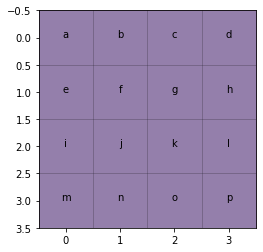

In [71]:
fig, ax = plt.subplots()

grid_gdf.plot(edgecolor='k', ax=ax, alpha=0.1)
# number our cells
for idx, row in grid_gdf.iterrows():
    ax.annotate(row['cell_id'], xy=row['coords'], horizontalalignment='center')

# some sample empty data
ax.imshow(np.zeros((4,4)), alpha=0.5)

Cool, our blank data works. Let's now implement our example.

In [72]:
# going to make this all by hand to make tracing easier
t1 = np.array([
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
t1

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [73]:
t2 = np.array([
    [1, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 0, 0, 0],
    [0, 1, 1, 1],
])
t2

array([[1, 1, 1, 0],
       [1, 1, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 1]])

In [74]:
t3 = np.array([
    [1, 0, 0, 0],
    [1, 0, 1, 1],
    [0, 0, 0, 0],
    [0, 1, 1, 1],
])
t3

array([[1, 0, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 1]])

In [75]:
t4 = np.array([
    [1, 0, 0, 0],
    [1, 0, 1, 1],
    [0, 0, 1, 1],
    [0, 1, 1, 1],
])
t4

array([[1, 0, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 1]])

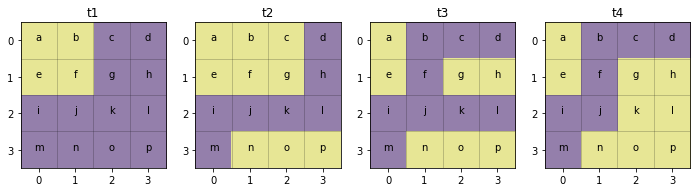

In [76]:
fig, axs = plt.subplots(1,4, figsize=(12,5))

for ax, t, label in zip(axs.ravel(), [t1, t2, t3, t4], ['t1', 't2', 't3', 't4']):

    grid_gdf.plot(edgecolor='k', ax=ax, alpha=0.1)
    # number our cells
    for idx, row in grid_gdf.iterrows():
        ax.annotate(row['cell_id'], xy=row['coords'], horizontalalignment='center')

    ax.imshow(t, alpha=0.5)
    ax.set_title(label)

Plotted above we now have the scenario I described:
- t1: event X appears in cells a, b, e, and f
- t2: event Y appears in cells n, o, p. event X has now grown into c and g as well
- t3: event X splits into events A and B, where A is in cells g and h, while B is in cells a and e. event Y remains uncahnged
- t4: event Y merges with event A, making the total event g, h, k, l, n, o, and p. Event B remains unchanged

I do not continue beyond this here because it demonstrates several key cases to first test:
- a new event is found
- events change size
- one event splits into two events
- one event merges with another event

Some other cases to consider would be:
- the split and merge occurring with 2+ events
- an event splits and merges with another event in the same time step
- multiple separate splits contribute to a single merge between the splits

Looking at the above scenario, we would want the following codes to be generated:
- t1: "1"
- t2: "1", "2"
- t3: "1-1", "1-2", "2"
- t4: "1-2", "2.1-2"

Let's now run our blob detection function on each time frame

In [77]:
vals = t1

(h, w) = vals.shape
t = (h, w, 3)
A = np.zeros(t, dtype=np.uint8)
for i in range(h):
    for j in range(w):
        # since we already made it binary, this
        # will make 1 vals be white and 0 vals
        # be black in our RGB array
        color_val = 255*vals[i,j]
        A[i, j] = [color_val, color_val, color_val]

# connectivity 2 will consider diagonals as connected
blobs = skimage.measure.label(rgb2gray(A) > 0, connectivity=2)

In [78]:
df_1 = identify_drought_blob(t1)
df_1

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,4,0,0,2,2,4,"[[0, 0], [0, 1], [1, 0], [1, 1]]",NaN


In [79]:
df_2 = identify_drought_blob(t2)
df_2

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,6,0,0,2,3,6,"[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]",NaN
1,3,3,1,4,4,3,"[[3, 1], [3, 2], [3, 3]]",NaN


In [80]:
df_3 = identify_drought_blob(t3)
df_3

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2,0,0,2,1,2,"[[0, 0], [1, 0]]",NaN
1,2,1,2,2,4,2,"[[1, 2], [1, 3]]",NaN
2,3,3,1,4,4,3,"[[3, 1], [3, 2], [3, 3]]",NaN


In [81]:
df_4 = identify_drought_blob(t4)
df_4

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2,0,0,2,1,2,"[[0, 0], [1, 0]]",NaN
1,7,1,1,4,4,8,"[[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2...",NaN


Okay, based on the areas counted, it looks like the blobs were correctly identified.

Let's pair them up using the function we made a bit ago.

In [82]:
blob_dict_t1_to_t2 = connect_blobs_over_time(df_1, df_2)
blob_dict_t1_to_t2

{0: 0}

That looks right, the 4 area grows to the 6 area, but the new 3 area was not in t1 and therefore would not have a connection

In [83]:
blob_dict_t2_to_t3 = connect_blobs_over_time(df_2, df_3)
blob_dict_t2_to_t3

{0: 0, 1: 0, 2: 1}

Cool, that caught that the 6 area goes to two 2 areas, and that the 3 area stays a three area despite it's index changing.

In [84]:
blob_dict_t3_to_t4 = connect_blobs_over_time(df_3, df_4)
blob_dict_t3_to_t4

{0: 0, 1: 2}

That got the 2 area staying as a 2 area ... but only one of the areas is preserved in the merge ... because it's a dictionary and therefore the result was overwritten. I can change that to tuples and then it won't be overwritten, cause if we just simply switch the keys and values then `blob_dict_t2_to_t3` would not catch the split and only retain one of them. 

In [85]:
def connect_blobs_over_time(df_1:pd.DataFrame, df_2:pd.DataFrame):
    """Identify blobs shared between time frames.

    Parameters
    ---------
    df_1 : pd.DataFrame
        Blob dataframe at first time index.
    df_2 : pd.DataFrame
        Blob dataframe at second time index.

    Returns
    -------
    list
        Indices to each dataframe denoting which
        blobs are shared, where each tuple in the
        list is connection. The first index of
        each tuple corresponds to df_1, while the
        second index correponds to df_2
    """

    blob_pairs = []

    for idx_1, df_1_coords in enumerate(df_1.coords.values):
        df_1_coords_set = set(tuple(coord) for coord in df_1_coords)
        for idx_2, df_2_coords in enumerate(df_2.coords.values):
            df_2_coords_set = set(tuple(coord) for coord in df_2_coords)
            if len(df_1_coords_set.intersection(df_2_coords_set)) > 0:
                blob_pairs.append((idx_1, idx_2))

    return blob_pairs

Double check now that our earlier test case gives us the same answers

In [86]:
connect_blobs_over_time(blobs_i500, blobs_i501)

[(0, 0), (1, 1)]

Cool. Now let's try our more elaborate test case out.

In [87]:
blob_con_t1_to_t2 = connect_blobs_over_time(df_1, df_2)
blob_con_t1_to_t2

[(0, 0)]

Good, same as before.

In [88]:
blob_con_t2_to_t3 = connect_blobs_over_time(df_2, df_3)
blob_con_t2_to_t3

[(0, 0), (0, 1), (1, 2)]

Still good. Can note the order of the indices is changed here since it just made more sense to me to preserve the order in which they were given.

In [89]:
blob_con_t3_to_t4 = connect_blobs_over_time(df_3, df_4)
blob_con_t3_to_t4

[(0, 0), (1, 1), (2, 1)]

Much better, now it's got both of the things that merge into the 7 area.

Now to use these to encode the blobs. This is where we start to get finicky with strings.

In [90]:
# setup some empty space to fill with ids
df_1['drought_id'] = np.nan*np.zeros(len(df_1))
df_2['drought_id'] = np.nan*np.zeros(len(df_2))
df_3['drought_id'] = np.nan*np.zeros(len(df_3))
df_4['drought_id'] = np.nan*np.zeros(len(df_4))

In [91]:
# want to keep track of what number we are on
new_blob_num = 1

for i in np.arange(len(df_1)):
    df_1['drought_id'].iloc[i] = f'{new_blob_num}'
    new_blob_num += 1

df_1

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,4,0,0,2,2,4,"[[0, 0], [0, 1], [1, 0], [1, 1]]",1


That was probably the easiest one. Now there needs to be communication between time steps

In [92]:
def propagate_drought_id(df_1=None, df_2=None, connections=[], new_blob_num=1):

    if len(connections) > 0:

        # need to keep track of splits among multiple
        # blobs (since they are 1-to-many and we are
        # iterating through linearly)
        split_origins = dict()

        for i in np.arange(len(df_2)):
            drought_id = ""

            # ALL CONNECTIONS
            # first we need to figure out if we are connected
            connects_origins = list()
            for connect in connections:
                # this means that our current index
                # connects to a previous time's index
                if connect[1] == i:
                    # we already know it's going to index i
                    # we need to figure out where it's coming from
                    connects_origins.append(connect[0])

            # SPLITS        
            # now we need to check if this is part of a split
            split_connections = dict()
            for origin in connects_origins:
                split_counter = 0
                for connect in connections:
                    # we want to count how many times the origin is
                    # connected to something ... if it ends up being
                    # more than once then it's a split
                    if connect[0] == origin:
                        split_counter += 1
                # meaning we found a split
                if split_counter > 1:
                    split_connections[origin] = split_counter
                    # if this is a new split we found, we
                    # should make sure to save a note of it
                    if origin not in split_origins.keys():
                        split_origins[origin] = 1
                
            # so this would be if the split was found        
            if len(split_connections) > 0:
                for split_origin in split_connections.keys():
                    split_origin_id = df_1['drought_id'].values[split_origin]
                    current_split_num = split_origins[split_origin]

                    drought_id = f'{split_origin_id}-{current_split_num}'
                    
                    # iterate for the next blob it splits into
                    split_origins[split_origin] += 1

            # MERGES
            # we have a merge if more than 1 blob
            # goes into this one
            if len(connects_origins) > 1:
                merged_blob_ids = df_1.iloc[connects_origins].sort_values('area', ascending=False)['drought_id'].values
                # double check if we already had a split and began
                # writing our code for this blob, if not we need to
                # set it up
                if len(drought_id) == 0:
                    drought_id = merged_blob_ids[0]
                for id in merged_blob_ids[1:]:
                    drought_id = f'{drought_id}.{id}'
                    
            # NO SPLIT NO MERGE        
            if len(connects_origins) == 1 and len(split_connections) == 0:
                drought_id = df_1.iloc[connects_origins[0]]['drought_id']
                

            # CONNECTIONS EXIST, BUT NEW BLOB
            if len(connects_origins) == 0:
                drought_id = f'{new_blob_num}'
                new_blob_num += 1    

            df_2['drought_id'].iloc[i] = drought_id                   

    else:
        # there were no connections, all id's start from scratch
        for i in np.arange(len(df_2)):
            df_2['drought_id'].iloc[i] = f'{new_blob_num}'
            new_blob_num += 1

    return df_2, new_blob_num

In [93]:
df_1

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,4,0,0,2,2,4,"[[0, 0], [0, 1], [1, 0], [1, 1]]",1


In [94]:
new_blob_num = 2
df_2, new_blob_num = propagate_drought_id(df_1, df_2, blob_con_t1_to_t2, new_blob_num)

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [95]:
new_blob_num

3

In [96]:
df_2

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,6,0,0,2,3,6,"[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]",1
1,3,3,1,4,4,3,"[[3, 1], [3, 2], [3, 3]]",2


In [97]:
df_3, new_blob_num = propagate_drought_id(df_2, df_3, blob_con_t2_to_t3, new_blob_num)

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [98]:
df_3

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2,0,0,2,1,2,"[[0, 0], [1, 0]]",1-1
1,2,1,2,2,4,2,"[[1, 2], [1, 3]]",1-2
2,3,3,1,4,4,3,"[[3, 1], [3, 2], [3, 3]]",2


In [99]:
df_4, new_blob_num = propagate_drought_id(df_3, df_4, blob_con_t3_to_t4, new_blob_num)

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [100]:
df_4

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords,drought_id
0,2,0,0,2,1,2,"[[0, 0], [1, 0]]",1-1
1,7,1,1,4,4,8,"[[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2...",2.1-2


Mwhahaha, it works!!!

Those are the test answers I was hoping for.

Now, can I put it all in a dataset and make some plots ...

In [101]:
grid_gdf

,geometry,cell_id,area,coords
a,"POLYGON ((-0.50000 -0.50000, 0.50000 -0.50000,...",a,1.0,"(0.0, 0.0)"
b,"POLYGON ((0.50000 -0.50000, 1.50000 -0.50000, ...",b,1.0,"(1.0, 0.0)"
c,"POLYGON ((1.50000 -0.50000, 2.50000 -0.50000, ...",c,1.0,"(2.0, 0.0)"
d,"POLYGON ((2.50000 -0.50000, 3.50000 -0.50000, ...",d,1.0,"(3.0, 0.0)"
e,"POLYGON ((-0.50000 0.50000, 0.50000 0.50000, 0...",e,1.0,"(0.0, 1.0)"
f,"POLYGON ((0.50000 0.50000, 1.50000 0.50000, 1....",f,1.0,"(1.0, 1.0)"
g,"POLYGON ((1.50000 0.50000, 2.50000 0.50000, 2....",g,1.0,"(2.0, 1.0)"
h,"POLYGON ((2.50000 0.50000, 3.50000 0.50000, 3....",h,1.0,"(3.0, 1.0)"
i,"POLYGON ((-0.50000 1.50000, 0.50000 1.50000, 0...",i,1.0,"(0.0, 2.0)"
j,"POLYGON ((0.50000 1.50000, 1.50000 1.50000, 1....",j,1.0,"(1.0, 2.0)"


In [102]:
empty_id = np.array([
    ["", "", "", ""],
    ["", "", "", ""],
    ["", "", "", ""],
    ["", "", "", ""],
], dtype=object_)

In [103]:
test_ds = xr.Dataset(
    coords=dict(
        x=np.arange(4),
        y=np.arange(4),
        time=np.arange(4)
    ),
    data_vars=dict(
        drought_measure=(["time", "y", "x"], [t1, t2, t3, t4]),
        drought_id=(["time", "y", "x"], [empty_id, empty_id, empty_id, empty_id])
    )
)
test_ds

<xarray.Dataset>
Dimensions:          (time: 4, y: 4, x: 4)
Coordinates:
  * x                (x) int64 0 1 2 3
  * y                (y) int64 0 1 2 3
  * time             (time) int64 0 1 2 3
Data variables:
    drought_measure  (time, y, x) int64 1 1 0 0 1 1 0 0 0 ... 1 0 0 1 1 0 1 1 1
    drought_id       (time, y, x) object '' '' '' '' '' '' ... '' '' '' '' '' ''

Double check we set that up right ...

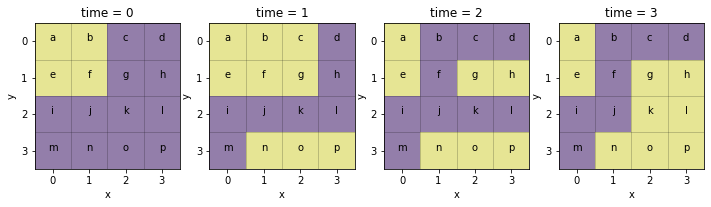

In [104]:
fig, axs = plt.subplots(1,4, figsize=(12,5))

for i, ax in enumerate(axs.ravel()):

    test_ds.isel(time=i)['drought_measure'].plot(ax=ax, alpha=0.5, add_colorbar=False)
    

    grid_gdf.plot(edgecolor='k', ax=ax, alpha=0.1)
    # number our cells
    for idx, row in grid_gdf.iterrows():
        ax.annotate(row['cell_id'], xy=row['coords'], horizontalalignment='center')

    ax.set_ylim(3.5, -0.5)


Cool, now to toss in the `drought_id`

In [105]:
df_1.coords.values[0]

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [106]:
t1_drought_id = test_ds.sel(time=0)['drought_id'].values

for i in np.arange(len(df_1)):
    for coord in df_1.coords.values[i]:
        t1_drought_id[coord[0], coord[1]] = df_1.drought_id.values[i]

t1_drought_id

array([['1', '1', '', ''],
       ['1', '1', '', ''],
       ['', '', '', ''],
       ['', '', '', '']], dtype=object)

In [107]:
test_ds.loc[{'time':0}]['drought_id'] = (("x", "y"), t1_drought_id)

In [108]:
test_ds.sel(time=0)['drought_id']

<xarray.DataArray 'drought_id' (y: 4, x: 4)>
array([['1', '1', '', ''],
       ['1', '1', '', ''],
       ['', '', '', ''],
       ['', '', '', '']], dtype=object)
Coordinates:
  * x        (x) int64 0 1 2 3
  * y        (y) int64 0 1 2 3
    time     int64 0

In [109]:
np.where(t1_drought_id == '1')

(array([0, 0, 1, 1]), array([0, 1, 0, 1]))

Cool, that's a little clunky but it's something

In [110]:
t2_drought_id = test_ds.sel(time=1)['drought_id'].values

for i in np.arange(len(df_2)):
    for coord in df_2.coords.values[i]:
        t2_drought_id[coord[0], coord[1]] = df_2.drought_id.values[i]

t2_drought_id

array([['1', '1', '1', ''],
       ['1', '1', '1', ''],
       ['', '', '', ''],
       ['', '2', '2', '2']], dtype=object)

In [111]:
test_ds.loc[{'time':1}]['drought_id'] = (("x", "y"), t2_drought_id)

In [112]:
t3_drought_id = test_ds.sel(time=2)['drought_id'].values

for i in np.arange(len(df_3)):
    for coord in df_3.coords.values[i]:
        t3_drought_id[coord[0], coord[1]] = df_3.drought_id.values[i]

t3_drought_id

array([['1-1', '', '', ''],
       ['1-1', '', '1-2', '1-2'],
       ['', '', '', ''],
       ['', '2', '2', '2']], dtype=object)

In [113]:
test_ds.loc[{'time':2}]['drought_id'] = (("x", "y"), t3_drought_id)

In [114]:
t4_drought_id = test_ds.sel(time=3)['drought_id'].values

for i in np.arange(len(df_4)):
    for coord in df_4.coords.values[i]:
        t4_drought_id[coord[0], coord[1]] = df_4.drought_id.values[i]

t4_drought_id

array([['1-1', '', '', ''],
       ['1-1', '', '2.1-2', '2.1-2'],
       ['', '', '2.1-2', '2.1-2'],
       ['', '2.1-2', '2.1-2', '2.1-2']], dtype=object)

In [115]:
test_ds.loc[{'time':3}]['drought_id'] = (("x", "y"), t4_drought_id)

In [116]:
test_ds['drought_id']

<xarray.DataArray 'drought_id' (time: 4, y: 4, x: 4)>
array([[['1', '1', '', ''],
        ['1', '1', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['1', '1', '1', ''],
        ['1', '1', '1', ''],
        ['', '', '', ''],
        ['', '2', '2', '2']],

       [['1-1', '', '', ''],
        ['1-1', '', '1-2', '1-2'],
        ['', '', '', ''],
        ['', '2', '2', '2']],

       [['1-1', '', '', ''],
        ['1-1', '', '2.1-2', '2.1-2'],
        ['', '', '2.1-2', '2.1-2'],
        ['', '2.1-2', '2.1-2', '2.1-2']]], dtype=object)
Coordinates:
  * x        (x) int64 0 1 2 3
  * y        (y) int64 0 1 2 3
  * time     (time) int64 0 1 2 3

So that's one way to do it ... but it also destroys any collective identity of the droughts, which was the whole purpose of this. Like it tracks them, but I can't easily grab the drought with id `1` across all time

When I have used encoding like this before, I had to make a whole object class to since it had to have internal knowledge of how to navigate itself.

Can I do this with the pandas dataframes?

In [117]:
df_1[['area', 'coords', 'drought_id']]

,area,coords,drought_id
0,4,"[[0, 0], [0, 1], [1, 0], [1, 1]]",1


In [118]:
test_df_all = pd.concat([df[['drought_id', 'area', 'coords']] for df in [df_1, df_2, df_3, df_4]])
test_df_all = test_df_all.reset_index()
test_df_all

,index,drought_id,area,coords
0,0,1,4,"[[0, 0], [0, 1], [1, 0], [1, 1]]"
1,0,1,6,"[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]"
2,1,2,3,"[[3, 1], [3, 2], [3, 3]]"
3,0,1-1,2,"[[0, 0], [1, 0]]"
4,1,1-2,2,"[[1, 2], [1, 3]]"
5,2,2,3,"[[3, 1], [3, 2], [3, 3]]"
6,0,1-1,2,"[[0, 0], [1, 0]]"
7,1,2.1-2,7,"[[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2..."


Hm, I'm missing times from this ... oh that could become a multiindex (ugh, but not much other choice)

In [119]:
for i, df in enumerate([df_1, df_2, df_3, df_4]):
    df['time'] = i

In [120]:
test_df_all = pd.concat([df[['time', 'drought_id', 'area', 'coords']] for df in [df_1, df_2, df_3, df_4]], ignore_index=True)
test_df_all = test_df_all.set_index(['time', 'drought_id'])
test_df_all

area                                             coords
time drought_id                                                         
0    1              4                   [[0, 0], [0, 1], [1, 0], [1, 1]]
1    1              6   [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
     2              3                           [[3, 1], [3, 2], [3, 3]]
2    1-1            2                                   [[0, 0], [1, 0]]
     1-2            2                                   [[1, 2], [1, 3]]
     2              3                           [[3, 1], [3, 2], [3, 3]]
3    1-1            2                                   [[0, 0], [1, 0]]
     2.1-2          7  [[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2...

OOOOO

Can I now extract a specific drought thread?

I'd want to find what id's have '1' as the first value or have a '.1' in them

In [121]:
# this will allow for easier searching I think
test_df_all['drought_id'] = test_df_all.index.get_level_values(1)
test_df_all

area                                             coords  \
time drought_id                                                            
0    1              4                   [[0, 0], [0, 1], [1, 0], [1, 1]]   
1    1              6   [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]   
     2              3                           [[3, 1], [3, 2], [3, 3]]   
2    1-1            2                                   [[0, 0], [1, 0]]   
     1-2            2                                   [[1, 2], [1, 3]]   
     2              3                           [[3, 1], [3, 2], [3, 3]]   
3    1-1            2                                   [[0, 0], [1, 0]]   
     2.1-2          7  [[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2...   

                drought_id  
time drought_id             
0    1                   1  
1    1                   1  
     2                   2  
2    1-1               1-1  
     1-2               1-2  
     2                   2  
3    1-1               1-1  
     2.1-2           2.1-2

In [122]:
drought_thread = [i for i, val in enumerate(test_df_all['drought_id']) if '1' in val or '.1' in val]
drought_thread

[0, 1, 3, 4, 6, 7]

In [123]:
thread_df = test_df_all.iloc[drought_thread]
thread_df

area                                             coords  \
time drought_id                                                            
0    1              4                   [[0, 0], [0, 1], [1, 0], [1, 1]]   
1    1              6   [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]   
2    1-1            2                                   [[0, 0], [1, 0]]   
     1-2            2                                   [[1, 2], [1, 3]]   
3    1-1            2                                   [[0, 0], [1, 0]]   
     2.1-2          7  [[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2...   

                drought_id  
time drought_id             
0    1                   1  
1    1                   1  
2    1-1               1-1  
     1-2               1-2  
3    1-1               1-1  
     2.1-2           2.1-2

Okay, I got those indexed ... now how do I plot?

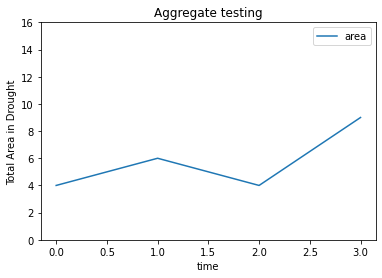

In [124]:
fig, ax = plt.subplots()

thread_df.groupby(level='time').sum().plot(ax=ax)
ax.set_ylim(0, 4*4)
ax.set_ylabel('Total Area in Drought')
ax.set_title('Aggregate testing');

So that get's me a plot I already could have made, which is a good sanity check, but now I want to get it split between the different events

This is what I'd want it to look like:

Text(0.5, 1.0, 'Evolution of Drought in Test')

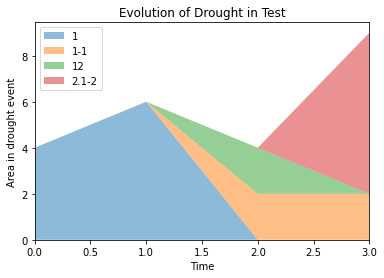

In [125]:
fig, ax = plt.subplots()

ax.stackplot(
    [0, 1, 2, 3], 
    [4, 6, 0, 0],
    [0, 0, 2, 2],
    [0, 0, 2, 0],
    [0, 0, 0, 7],
    alpha=0.5,
    labels=['1','1-1', '12', '2.1-2']

)

ax.set_xlim(0,3)
ax.legend(loc='upper left')

ax.set_xlabel('Time')
ax.set_ylabel('Area in drought event')
ax.set_title('Evolution of Drought in Test')

alright, so more time intervals the better to get rid of the interpolation, but you can see here that after time 1, event `1` split into `1-1` and `1-2`. Then at time 2 can see that `1-2` got absorbed into `2.1-2`

Now to figure out how to translate `thread_df` into that

So I need the 0's for the whole time ... and then I can grab the areas for which times they correspond to ...

In [126]:
times = np.arange(4)
template = np.zeros(4)

unique_drought_id = sorted(set(thread_df['drought_id'].values))
print(unique_drought_id)

['1', '1-1', '1-2', '2.1-2']


In [127]:
droughts = []


for id in unique_drought_id:
    event_df = thread_df[thread_df.drought_id == id]
    times = event_df.index.get_level_values(0)
    event_array = template.copy()

    for time in times:
        event_array[time] = event_df.loc[time]['area']
    
    droughts.append(event_array)

In [128]:
droughts

[array([4., 6., 0., 0.]),
 array([0., 0., 2., 2.]),
 array([0., 0., 2., 0.]),
 array([0., 0., 0., 7.])]

Text(0.5, 1.0, 'Evolution of Drought in Test')

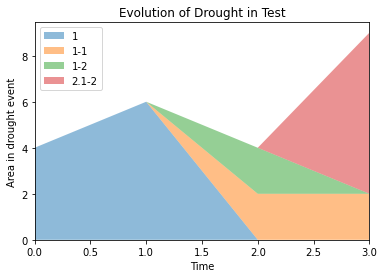

In [129]:
fig, ax = plt.subplots()

ax.stackplot(
    [0, 1, 2, 3], 
    *droughts,
    alpha=0.5,
    labels=unique_drought_id
 
)

ax.set_xlim(0,3)
ax.legend(loc='upper left')

ax.set_xlabel('Time')
ax.set_ylabel('Area in drought event')
ax.set_title('Evolution of Drought in Test')

Woot

LOVE IT. WE HAVE A FULL WORKFLOW!!!

Let's wrap the dataframe creation and plotting into functions

Then I'll need to do handling from the xarray data ... which actually shouldn't be too hard

Hm. Since the dataframe creation is just concation ... let's go ahead and wrap that into pulling the data from xarray and running it through the circus

In [130]:
# want to remind myself the structure of this
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 0
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

In [131]:
paired_ds['USDM'].values.shape[0]

1148

In [253]:
def encode_drought_events(data:np.ndarray):
    """Detect and encode drought events.

    Parameters
    ----------
    data: np.ndarray
        Expecting first index to be temporal while second
        and third are spatial.

    Returns
    -------
    pd.DataFrame
        A multi-indexed dataframe with time as the first level
        and drought_id as the second level. 'area', 'convex_area',
        and 'coords' are also outputted in this dataframe computed 
        from sci-kit image. Note that times that did not have a
        drought will not appear in this dataframe.
    
    """
    blob_dfs = []

    for i in tqdm(np.arange(data.shape[0]), desc='Identifying Blobs'):
        blob_dfs.append(identify_drought_blob(data[i,:,:]))
    

    #return blob_dfs

    new_blob_num = 1
    init_df, new_blob_num = propagate_drought_id(df_2=blob_dfs[0])
    init_df['time'] = 0
    encoded_blob_dfs = [init_df]    
    for i in tqdm(np.arange(len(blob_dfs)-1), desc='Encoding Blobs'):
        df_1 = encoded_blob_dfs[i]
        df_2 = blob_dfs[i+1]

        blob_pairs = connect_blobs_over_time(df_1, df_2)
        df_2_encoded, new_blob_num = propagate_drought_id(df_1, df_2, blob_pairs, new_blob_num)
        df_2_encoded['time'] = i+1
        encoded_blob_dfs.append(df_2_encoded)

    all_blobs_df = pd.concat([df[['time', 'drought_id', 'area', 'convex_area', 'coords']] for df in encoded_blob_dfs], ignore_index=True)
    all_blobs_df = all_blobs_df.set_index(['time', 'drought_id'])
    all_blobs_df['drought_id'] = all_blobs_df.index.get_level_values(1)

    return all_blobs_df

In [189]:
t_all = np.array([t1, t2, t3, t4])

test_output = encode_drought_events(t_all)
test_output

Identifying Blobs:   0%|          | 0/4 [00:00<?, ?it/s]

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Encoding Blobs:   0%|          | 0/3 [00:00<?, ?it/s]

area  convex_area  \
time drought_id                      
0    1              4            4   
1    1              6            6   
     2              3            3   
2    1-1            2            2   
     1-2            2            2   
     2              3            3   
3    1-1            2            2   
     2.1-2          7            8   

                                                            coords drought_id  
time drought_id                                                                
0    1                            [[0, 0], [0, 1], [1, 0], [1, 1]]          1  
1    1            [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]          1  
     2                                    [[3, 1], [3, 2], [3, 3]]          2  
2    1-1                                          [[0, 0], [1, 0]]        1-1  
     1-2                                          [[1, 2], [1, 3]]        1-2  
     2                                    [[3, 1], [3, 2], [3, 3]]          2  
3    1-1                                          [[0, 0], [1, 0]]        1-1  
     2.1-2       [[1, 2], [1, 3], [2, 2], [2, 3], [3, 1], [3, 2...      2.1-2

Success!

Now for the plotting function

In [242]:
def plot_drought_evolution(df:pd.DataFrame, event_id='', plot_var='area', ax=None, plot_legend=True):
    """Plots the evolution of droughts over time from blob detection.

    Parameters
    ----------
    df : pd.DataFrame
        Expected to be the output of encode_drought_events
    event_id : str (optional)
        The initial drought_id of the drought wishing to follow.
        Defaults as '' to plot everything.
    plot_var : str (optional)
        Variable from df to plot, defaults as 'area' to plot pixel
        area computed from blob detection.
    ax (optional)
        matplotlib axes object to plot on. one will be created
        if not given.
    plot_legend : boolean
        Whether to plot the legend (which can sometimes be quite long).
        Defaults as True to plot the legend
    """

    assert(isinstance(event_id, str))

    if ax is None:
        __, ax = plt.subplots()

    related_events_idx = [i for i, val in enumerate(df['drought_id']) if f'{event_id}' in val or f'.{event_id}' in val]
    thread_df = df.iloc[related_events_idx]

    # need to grab the last value since we aren't going to get a df to plot
    # from times when there is no drought
    times = np.arange(df.index.get_level_values(0)[-1]+1)
    template = np.zeros(len(times))

    unique_drought_id = sorted(set(thread_df['drought_id'].values))

    droughts = []
    for id in unique_drought_id:
        event_df = thread_df[thread_df.drought_id == id]
        event_array = template.copy()
        event_times = event_df.index.get_level_values(0)

        for time in event_times:
            event_array[time] = event_df.loc[time][plot_var]
        
        droughts.append(event_array)

    ax.stackplot(times, *droughts, labels=unique_drought_id)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{plot_var} in drought event')

    if plot_legend:
        ax.legend()

    return ax

<AxesSubplot:xlabel='Time', ylabel='area in drought event'>

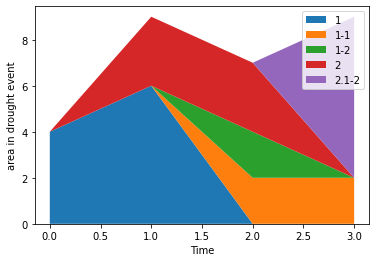

In [239]:
plot_drought_evolution(test_output)

<AxesSubplot:xlabel='Time', ylabel='area in drought event'>

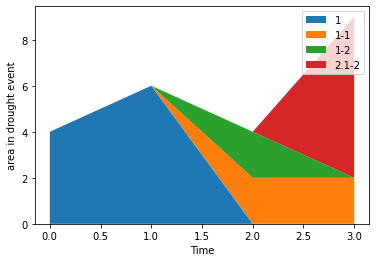

In [240]:
plot_drought_evolution(test_output, '1')

Awesome. That worked out nicely.

Now can I do this for our actual data?

In [211]:
USDM_events = encode_drought_events(paired_ds['USDM'].values)

Identifying Blobs:   0%|          | 0/1148 [00:00<?, ?it/s]

Encoding Blobs:   0%|          | 0/1147 [00:00<?, ?it/s]

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [247]:
USDM_events['frac_area'] = USDM_events['area']/(84*188)
USDM_events

area  convex_area  \
time drought_id                                 
56   1                       653          665   
57   1                       653          665   
58   1                     12006        13514   
     2                        37           65   
     3                         1            1   
...                          ...          ...   
1144 75.76.77.78-1.80-1-2      2            2   
1145 75.76.77.78-1.80-1-1   6861         7561   
     75.76.77.78-1.80-1-2      2            2   
1146 75.76.77.78-1.80-1-1   6771         7276   
1147 75.76.77.78-1.80-1-1   6810         7316   

                                                                      coords  \
time drought_id                                                                
56   1                     [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
57   1                     [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
58   1                     [[0, 49], [0, 50], [0, 51], [0, 52], [0, 53], ...   
     2                     [[6, 41], [7, 41], [7, 43], [7, 44], [7, 45], ...   
     3                                                            [[10, 53]]   
...                                                                      ...   
1144 75.76.77.78-1.80-1-2                               [[82, 62], [82, 63]]   
1145 75.76.77.78-1.80-1-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   
     75.76.77.78-1.80-1-2                               [[82, 62], [82, 63]]   
1146 75.76.77.78-1.80-1-1  [[0, 114], [0, 115], [0, 116], [0, 117], [0, 1...   
1147 75.76.77.78-1.80-1-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   

                                     drought_id  frac_area  
time drought_id                                             
56   1                                        1   0.041350  
57   1                                        1   0.041350  
58   1                                        1   0.760258  
     2                                        2   0.002343  
     3                                        3   0.000063  
...                                         ...        ...  
1144 75.76.77.78-1.80-1-2  75.76.77.78-1.80-1-2   0.000127  
1145 75.76.77.78-1.80-1-1  75.76.77.78-1.80-1-1   0.434460  
     75.76.77.78-1.80-1-2  75.76.77.78-1.80-1-2   0.000127  
1146 75.76.77.78-1.80-1-1  75.76.77.78-1.80-1-1   0.428761  
1147 75.76.77.78-1.80-1-1  75.76.77.78-1.80-1-1   0.431231  

[1408 rows x 5 columns]

<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

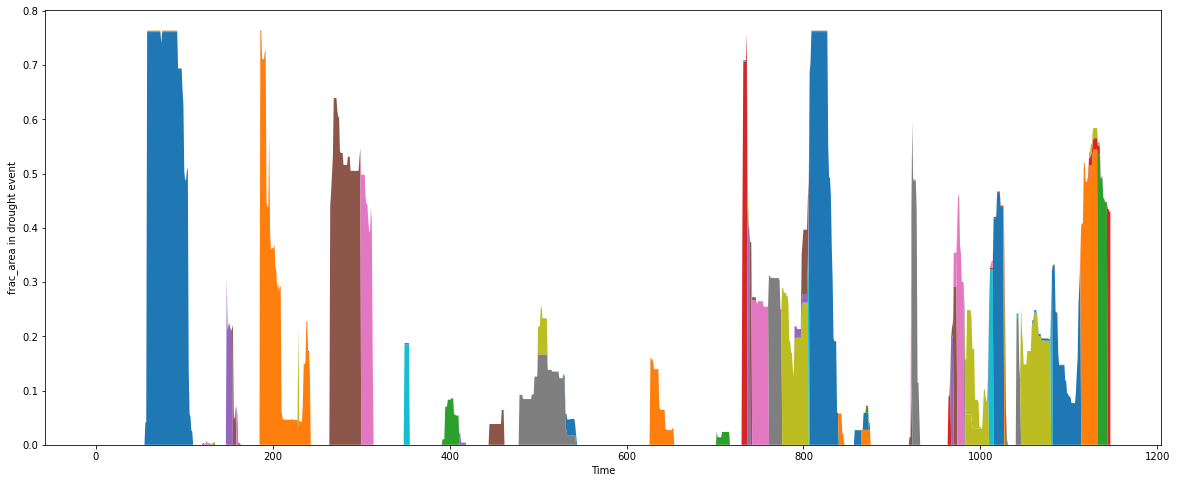

In [251]:
fig, ax = plt.subplots(figsize=(20, 8))

plot_drought_evolution(USDM_events, plot_legend=False, ax=ax, plot_var='frac_area', event_id='')

Fuck yeah. Think the only thing that's left is to do some polishing on that plot like coloring the droughts according to a colormap instead of the defaults so we can better track new events

<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

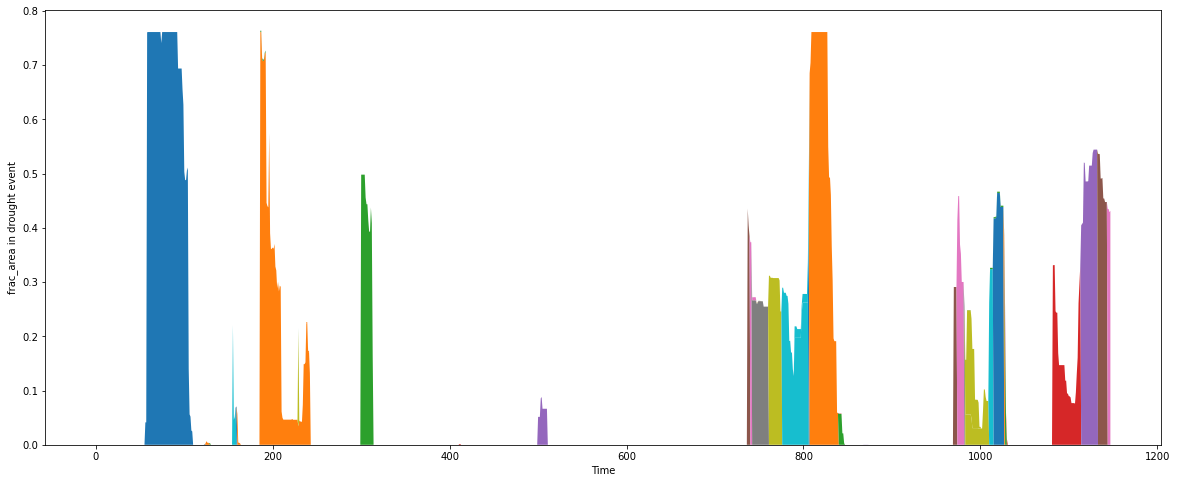

In [250]:
fig, ax = plt.subplots(figsize=(20, 8))

plot_drought_evolution(USDM_events, plot_legend=False, ax=ax, plot_var='frac_area', event_id='1')

Ah, so it's picking up the splits that then have a `1` in them ... need to figure out a way around that

<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

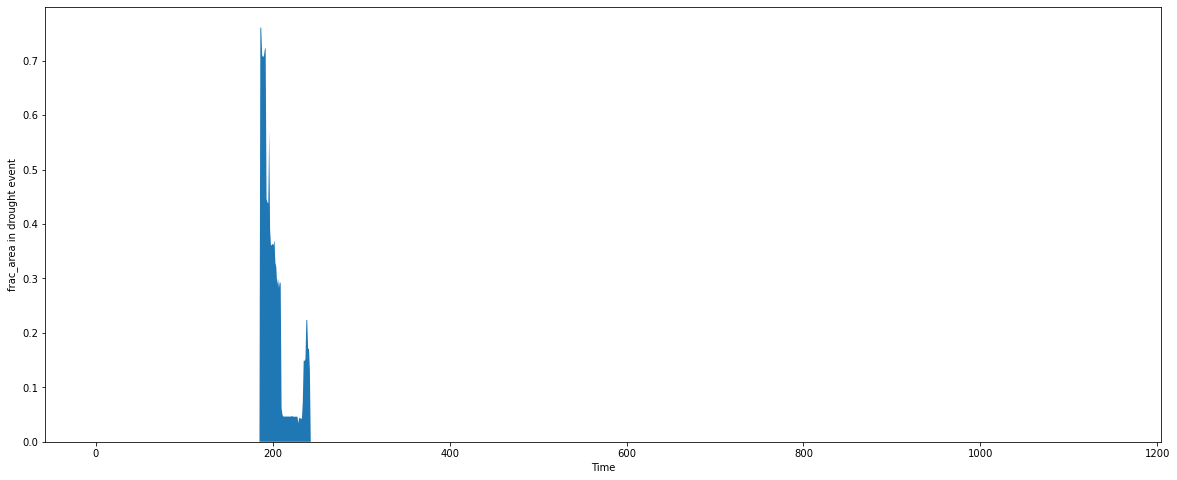

In [252]:
fig, ax = plt.subplots(figsize=(20, 8))

plot_drought_evolution(USDM_events, plot_legend=False, ax=ax, plot_var='frac_area', event_id='10')